In [4]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [5]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
#from lib.models import FcNN, MyFCNNActorProb, MyFCNNActorProb2, MyFcnnActor, MyCritc, Backbone
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [3]:
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
                  99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
                  160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]

train_seeds = seeds[:30]
val_seeds = seeds[30:]
test_seeds = np.array([69, 33, 420])

print(train_seeds)
print(val_seeds)

[102 348 270 106  71 188  20 121 214 330  87 372  99 359 151 130 149 308
 257 343 413 293 385 191 276 160 313  21 252 235]
[344  42]


# iterate through all seeds and print intial voriticity in a grid

In [ ]:
vorts = np.zeros((seeds.shape[0], 128,128))
for i in range(seeds.shape[0]):
    env = KolmogorovEnvironment6(seeds=np.array([seeds[i]]))
    vorts[i,...] = env.get_vorticity()
    env.close()


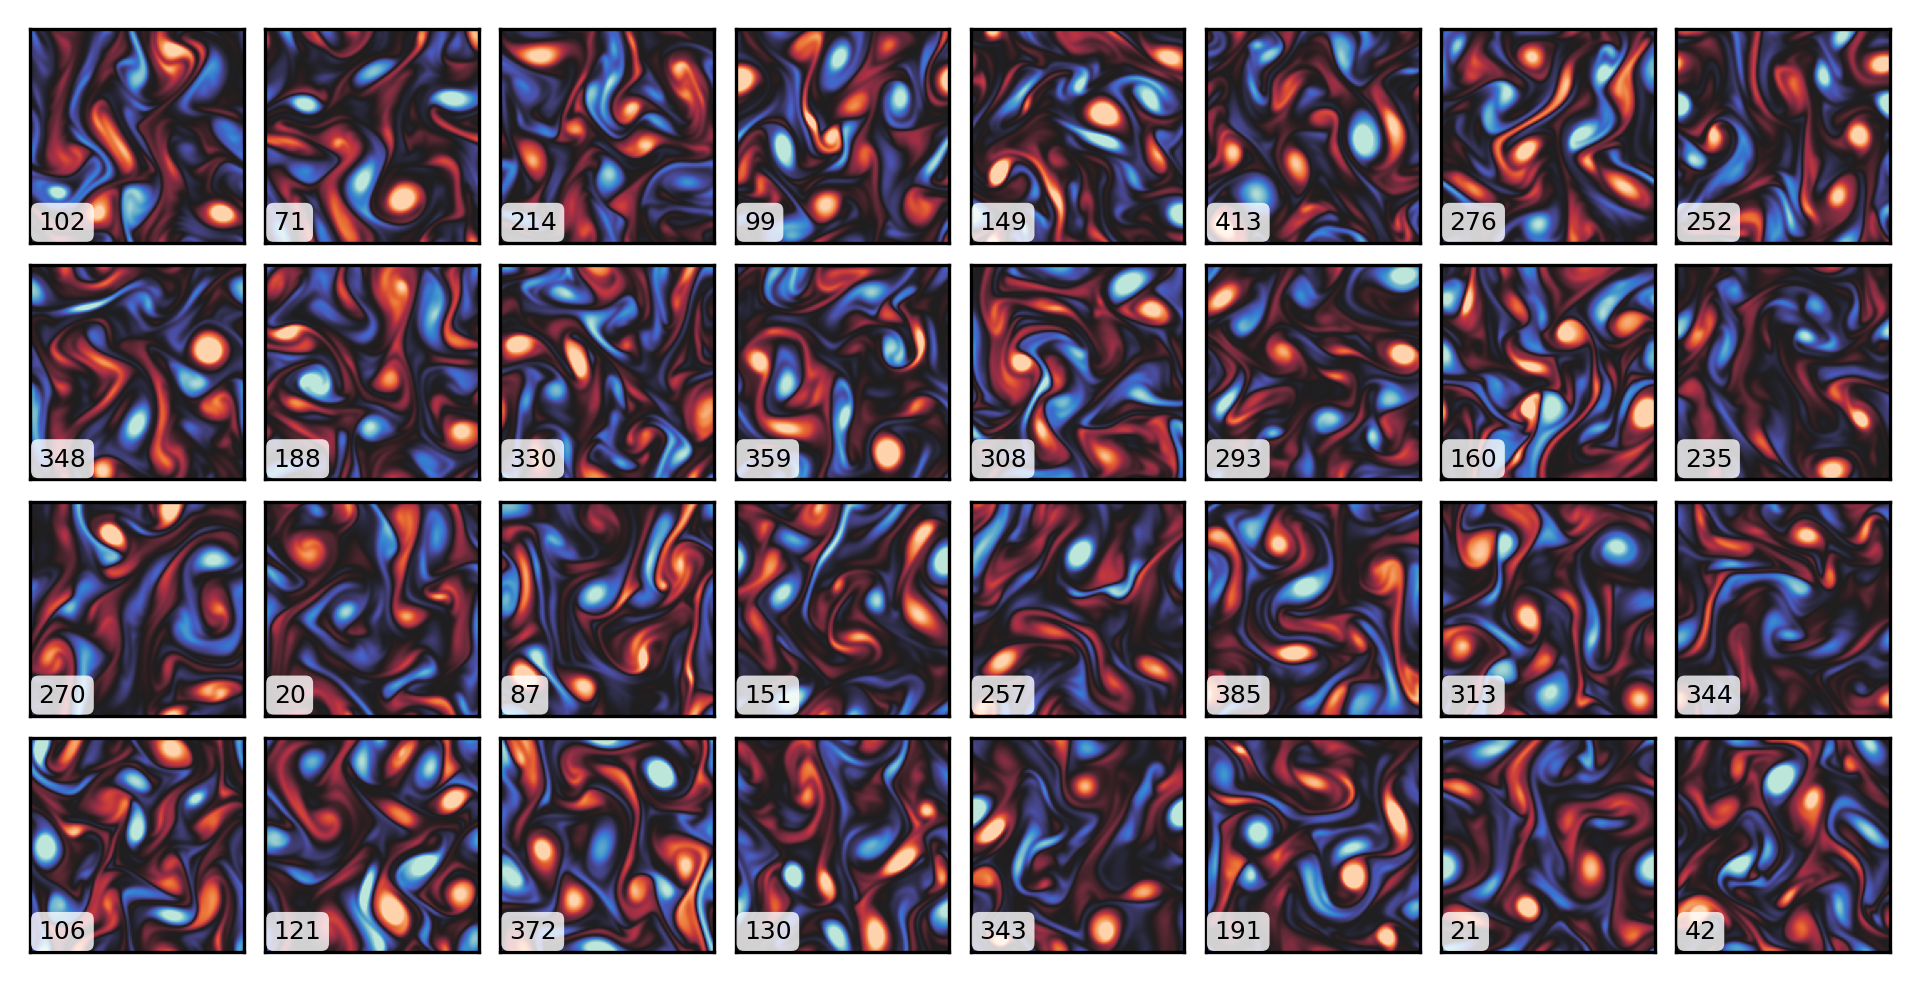

In [ ]:
# plot vorticity images at times t1 to t5 for all resolutions
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.8)
fig, axs = plt.subplots(4, 8, figsize=(8,4), dpi=300)
# add tight layout
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(8):
    for j in range(4):     
        axs[j, i].imshow(vorts[4*i+j], vmin=-12, vmax=12, cmap=sn.cm.icefire)
        #axs[j, i].axis('off')
        # disable ticks 
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].text(0.04, 0.04, f"{seeds[4*i+j]}", ha='left', va='bottom', fontsize=6, color='black', bbox=bbox_props, transform=axs[j,i].transAxes)
plt.show()

# plot energy spectrum over the coarse of a simulation between fgs and cgs

In [4]:
env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=1536-1, step_factor=1)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


0 0
Correlation: 0.9991326297480867
MSE: 8.389118945742234e-05
NMSE: 8.060004477498618e-05
pointwise relative mse: 1.0171380309686808


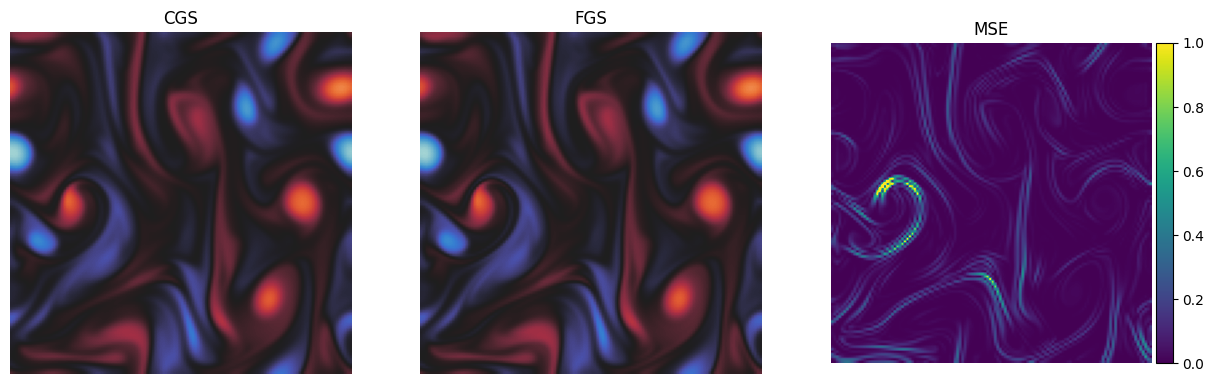

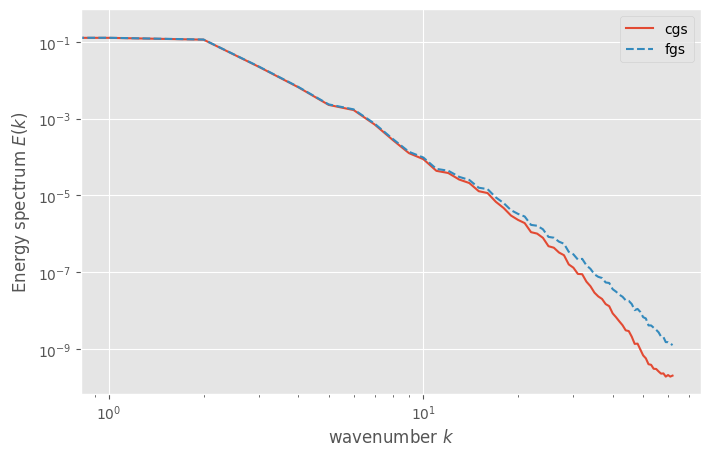

200 -0.7683228227189574
Correlation: 0.9899498983925331
MSE: 0.0017278398002813595
NMSE: 0.0016645731190159747
pointwise relative mse: 7.081220723886739


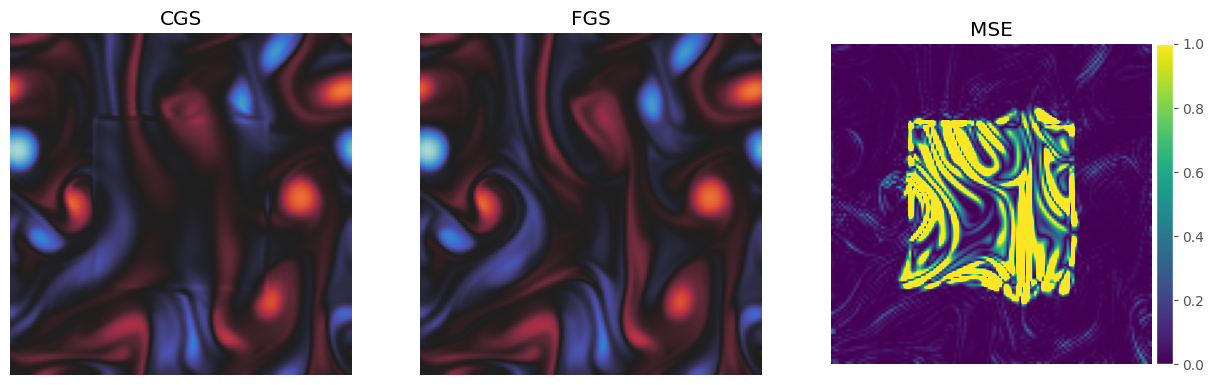

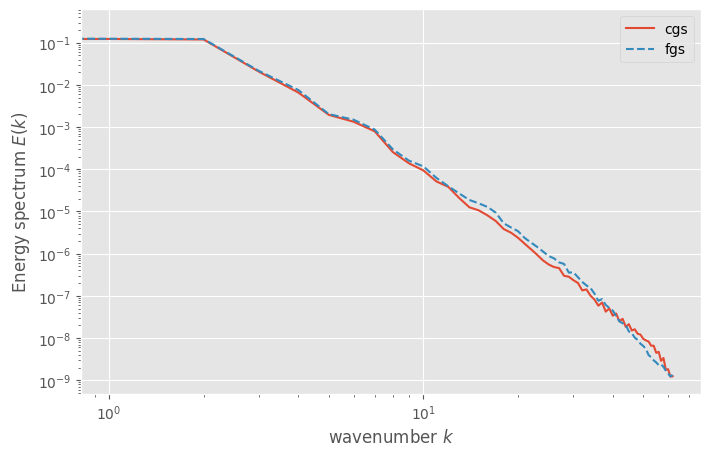

400 -0.9943211295144181
Correlation: 0.983522951753881
MSE: 0.004251786987393737
NMSE: 0.004113598729605161
pointwise relative mse: 25.42085819926624


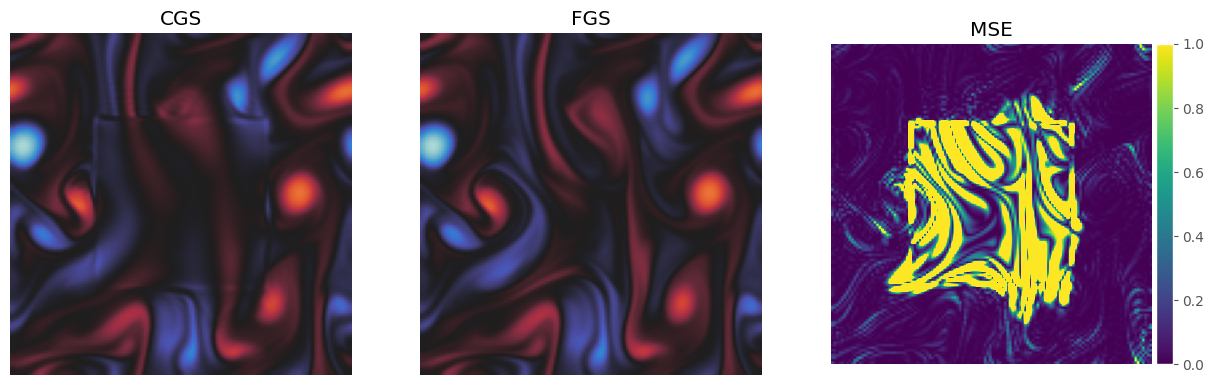

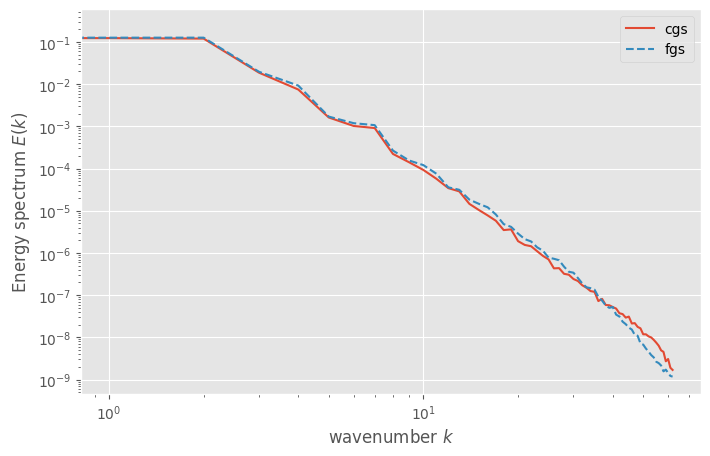

600 -1.1485728130200528
Correlation: 0.9773406461816534
MSE: 0.0073041442185312454
NMSE: 0.007109715326537871
pointwise relative mse: 46976.07699756575


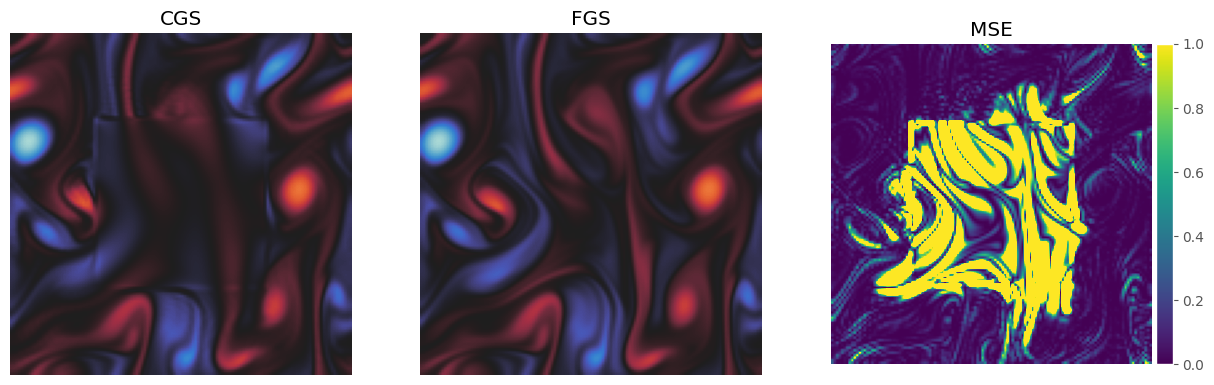

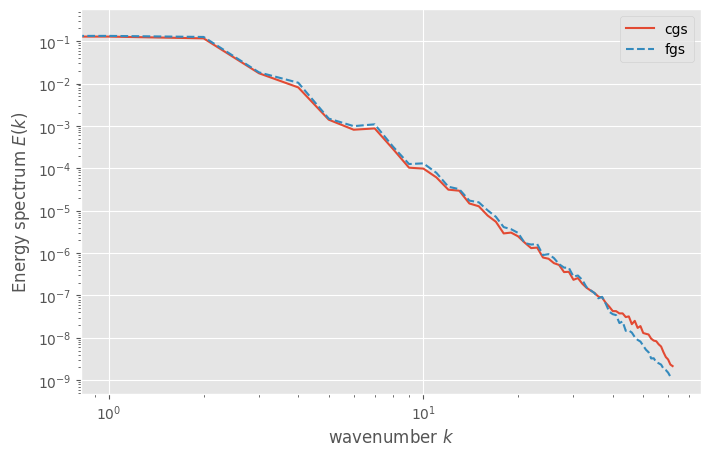

terminated
#steps = 791, Total Reward = -734.9295410937907
Execution time: 5.275259494781494 seconds


In [6]:
import time
#time one klmgrv5 episode
start_time = time.time()
reward = 0
step = 0
act = np.ones(env.action_space.shape)
act[32:96, 32:96] = 0.92
obs ,inf = env.reset()
rew = 0
episode_is_over = False
while not episode_is_over:
    if step%200==0:
        print(step, rew)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()

        #plot enerty spectra
        E1, E2 = env.get_spectra()
        plt.style.use('ggplot')
        plt.figure(figsize=(8, 5), dpi=100)
        plt.loglog(E1, label='cgs')
        plt.loglog(E2, linestyle='dashed', label='fgs')
        plt.ylabel(r'Energy spectrum $E(k)$')
        plt.xlabel(r'wavenumber $k$')
        plt.legend()
        plt.show()

    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True



print(f"#steps = {step}, Total Reward = {reward}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# load and look at trained policz

In [6]:
# load args
DUMP_PATH = "dump/Kolmogorov6_ppo_cgs1_fgs16/"

with open(DUMP_PATH+'config_20240809-114948.pkl', 'rb') as f:
    args = pickle.load(f)

In [8]:
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
                  99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
                  160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:30]
val_seeds = seeds[30:]
#test_seeds = np.array([69, 33, 420])

train_env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)
test_env = KolmogorovEnvironment7(seeds=val_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0
m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


In [9]:
actor = MyFCNNActorProb(in_channels=2, device=device).to(device)
critic_backbone = Backbone(in_channels=2, device=device).to(device)
critic = Critic(preprocess_net=critic_backbone, preprocess_net_output_dim=64, device=device).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = PPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=args.deterministic_eval,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

In [10]:
#load trained bolicy
policy.load_state_dict(torch.load(DUMP_PATH+'policy_20240809-114948.pth'))

<All keys matched successfully>

mean=-0.08347243070602417, std=0.001485285465605557, act=-0.08347243070602417, scaled act = 0.9916720986366272
Correlation: 0.9962402566751966
MSE: 0.00029111683626492423
NMSE: 0.00042719021865913516
pointwise relative mse: 4.197891056582132


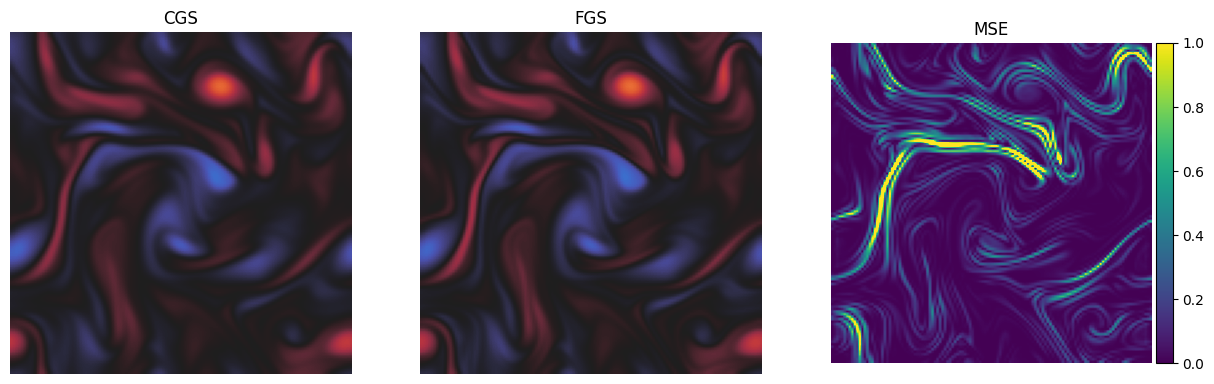

mean=-0.08347426354885101, std=0.0014849944273009896, act=-0.08347426354885101, scaled act = 0.9916719198226929
Correlation: 0.9925273118586609
MSE: 0.0007554884433478383
NMSE: 0.00110852388173484
pointwise relative mse: 28.942185067151144


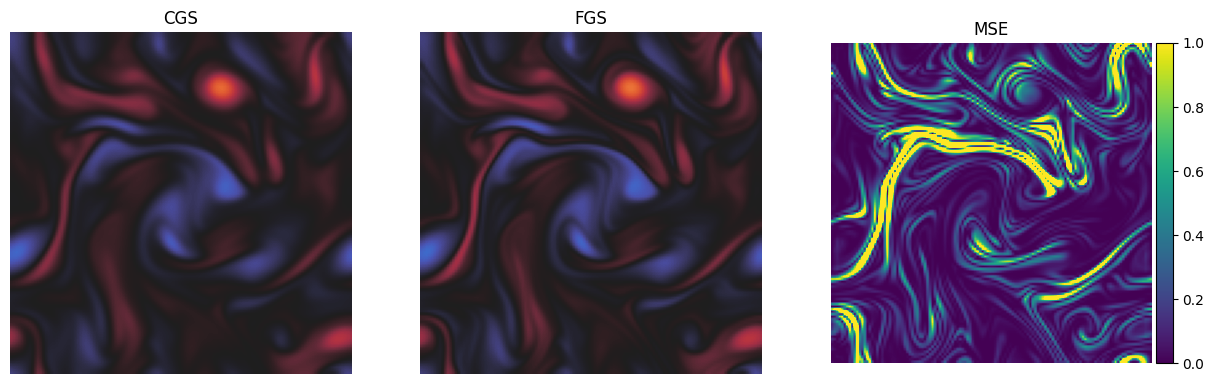

mean=-0.0834769606590271, std=0.0014845661353319883, act=-0.0834769606590271, scaled act = 0.991671621799469
Correlation: 0.988795386446927
MSE: 0.001365055593379713
NMSE: 0.0019974963034274577
pointwise relative mse: 19.207404836180952


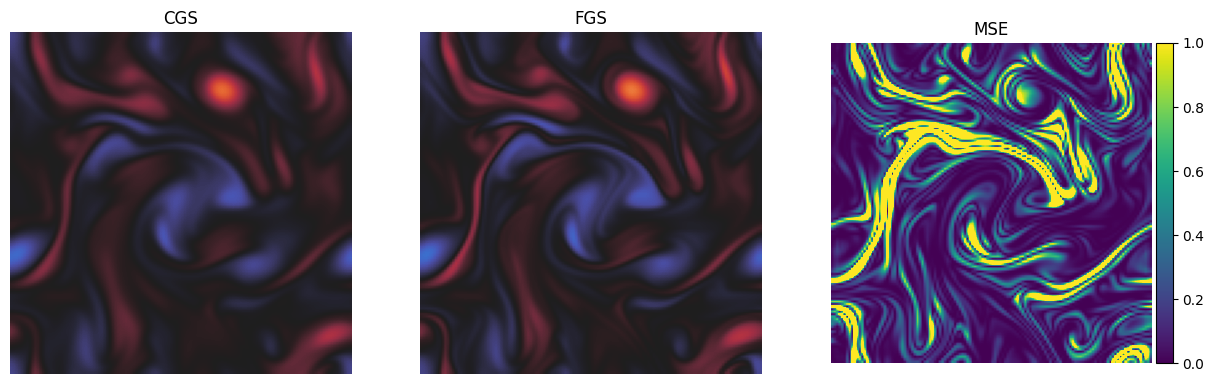

mean=-0.0834810882806778, std=0.0014839069917798042, act=-0.0834810882806778, scaled act = 0.9916712045669556
Correlation: 0.9853356167135459
MSE: 0.002100438595579518
NMSE: 0.003059071047870259
pointwise relative mse: 48.3090947573433


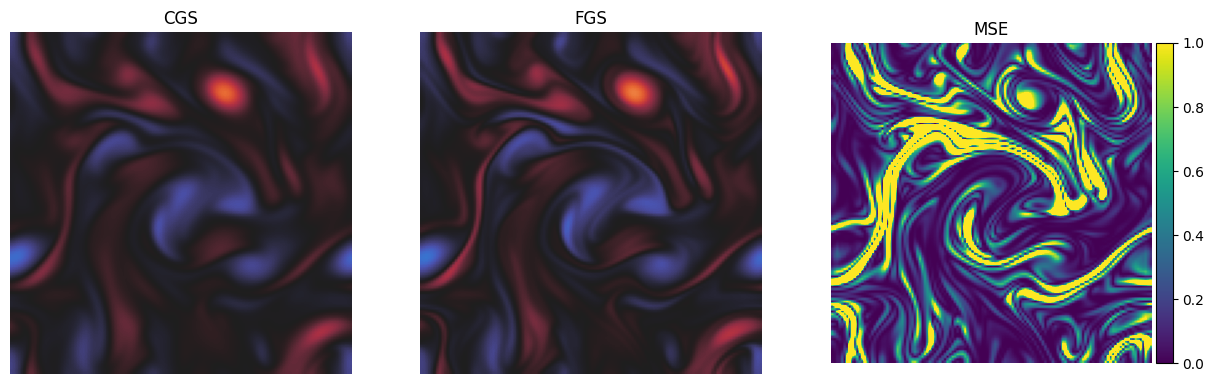

mean=-0.08348619937896729, std=0.001483093947172165, act=-0.08348619937896729, scaled act = 0.9916707277297974
Correlation: 0.9821525670545511
MSE: 0.002952706612672253
NMSE: 0.004275604143618224
pointwise relative mse: 2168.0687817556623


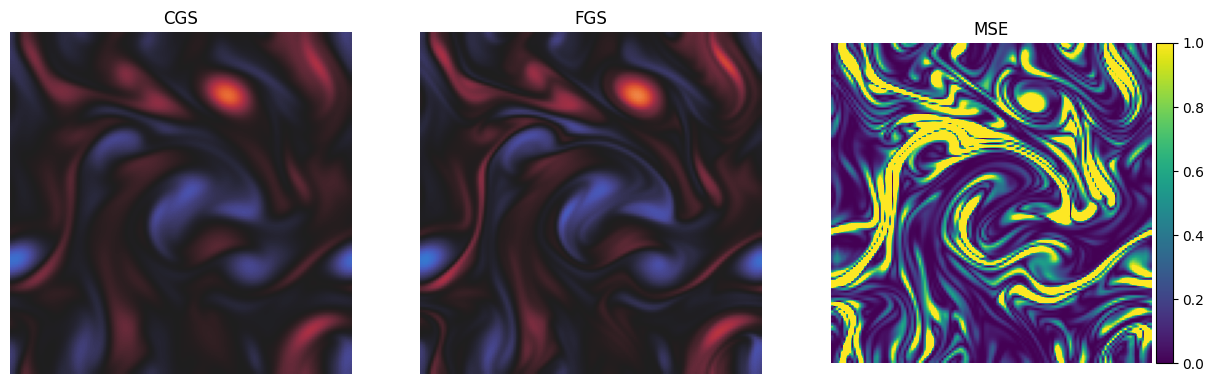

mean=-0.08349066972732544, std=0.0014823877718299627, act=-0.08349066972732544, scaled act = 0.9916703104972839
Correlation: 0.9790132450025664
MSE: 0.003912832324347091
NMSE: 0.0056365432885539905
pointwise relative mse: 177.22673747939203


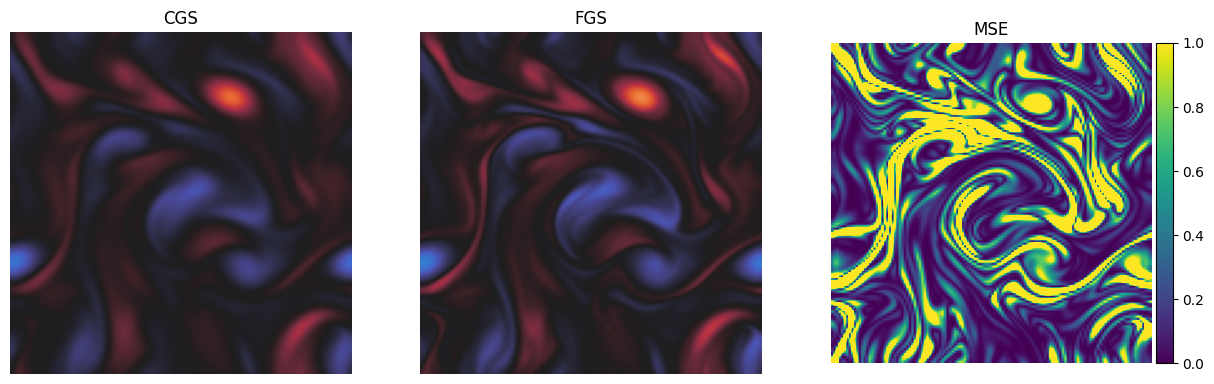

mean=-0.08349356055259705, std=0.0014819344505667686, act=-0.08349356055259705, scaled act = 0.9916700124740601
Correlation: 0.9757411266095594
MSE: 0.0049793159134805635
NMSE: 0.0071505258746268514
pointwise relative mse: 69.85646658848867


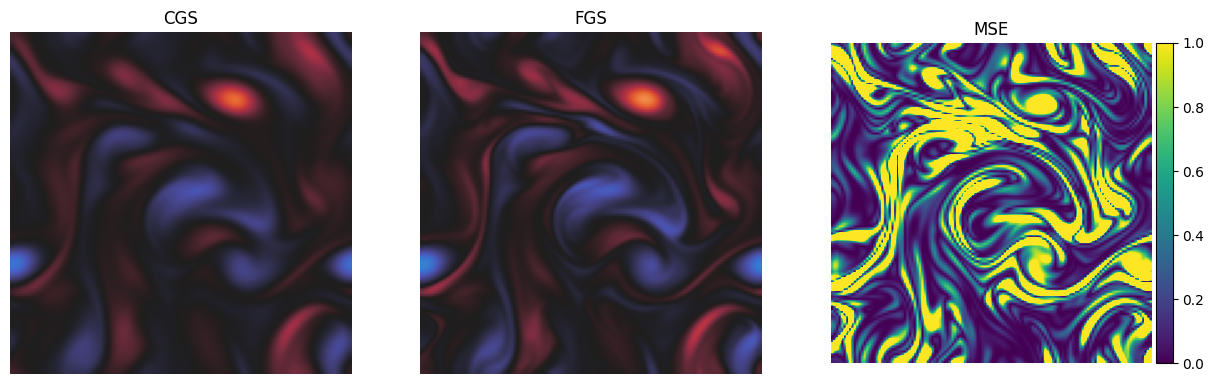

truncated
#steps = 1535, Total Reward = -269.49686744323253


NameError: name 'env' is not defined

In [12]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
act_means = []
act_maxs = []
act_mins = []
act_stds = []
std_means = []
episode_is_over = False
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    #act_means.append(logits[0].reshape(128,128).mean())
    #act_mins.append(logits[0].reshape(128,128).min())
    #act_maxs.append(logits[0].reshape(128,128).max())
    act_means.append(act.reshape(128,128).mean())
    act_mins.append(act.reshape(128,128).min())
    act_maxs.append(act.reshape(128,128).max())
    act_stds.append(act.reshape(128,128).std())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    reward += rew
    step += 1
    if step%200==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        test_env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
test_env.close()

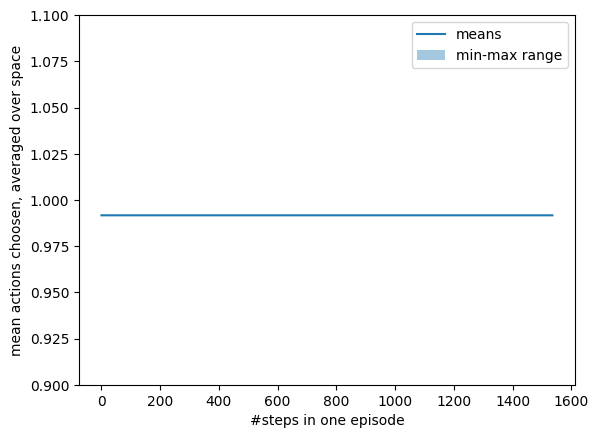

In [13]:
act_means = np.array(act_means)
act_maxs =np.array( act_maxs)
act_mins =np.array( act_mins)
act_stds =np.array( act_stds)
std_means = np.array(std_means)

#this plots the mean, max and min of actions computed over space as a plot over the time of one episode
t = np.linspace(1, len(act_means),len(act_means))
plt.figure()
plt.plot(t, act_means, label="means")
plt.fill_between(t, act_mins, act_maxs, alpha=0.4, label="min-max range")
#plt.fill_between(t, act_means-act_stds, act_means+act_stds, alpha=0.4, label="min-max range")
#plt.plot(t, act_mins, label="mins")
#plt.plot(t, act_maxs, label="maxs")
plt.ylim([0.9,1.1])
plt.legend()
plt.xlabel("#steps in one episode")
plt.ylabel("mean actions choosen, averaged over space")
plt.show()

In [14]:
obs, inf = test_env.reset()
mean, std = policy(Batch(obs=np.array([obs]), info={})).logits.detach().cpu().numpy()
acts_taken = policy(Batch(obs=np.array([obs]), info={})).act.detach().cpu().numpy().reshape(128,128)
mean, std = mean.reshape(128,128), std.reshape(128,128)

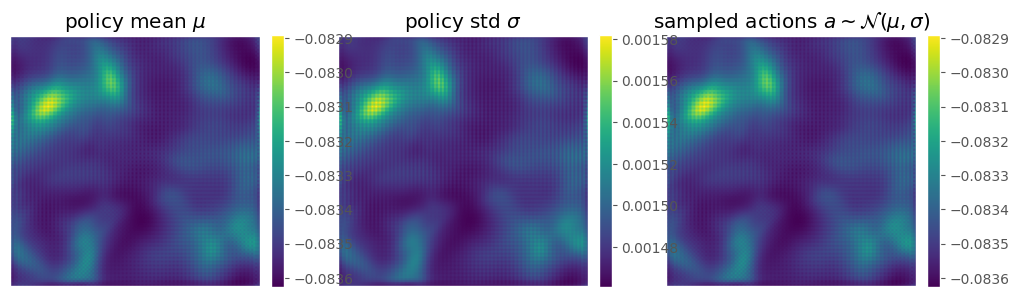

In [15]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', origin='lower')
im2 = axs[1].imshow(std, cmap='viridis', aspect='equal', origin='lower')
im3 = axs[2].imshow(acts_taken, cmap='viridis', aspect='equal', origin='lower')

axs[0].set_title(r"policy mean $\mu$")
axs[1].set_title(r"policy std $\sigma$")
axs[2].set_title(r"sampled actions $a \sim \mathcal{N}(\mu, \sigma)$")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xticks([])


cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
plt.show()